In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

X, y = mnist.data, mnist.target

X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

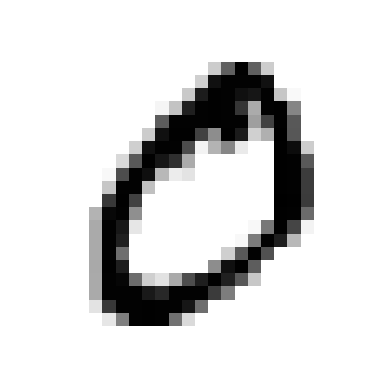

In [14]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [15]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

y_train_5 = (y_train == '5') # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

In [16]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5) 
# Bu kısımda, binary classification yapılıyor. y_train_5 yani 5'leri gördüğünde true, başka bir şey gördüğünde false
# Eğer doğru karıştırılmış bir dataset ise 10 tane rakam olacağı için %10'a true, %90'a false diyecek
# False demeyi öğreniyor daha çok çünkü true case'ler çok daha az

sgd_clf.predict([some_digit])

array([False])

In [17]:
# PERFORMANCE MEASURES

from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
# Cross validation = Training ve test set diye ayırdık. Training set içerisinde validation set ayırdık
# Normalde validation hatası training hatasından büyük çıkıyor ve büyük çıkmaya devam ediyorsa overfitting var diyorduk
# Bu durumda validation kısmı bizim training'imizin ne kadar iyi çalıştığını gösteriyor
# Bu durumda 3 kere cross validation yaparak validation set'in pozisyonunu training set'te o kadar değiştiriyoruz

array([0.95035, 0.96035, 0.9604 ])

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3) # add shuffle=True if the dataset is
                                      # not already shuffled
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold) # Number of correct cases
    print(n_correct / len(y_pred)) 
    
# 0-9'a kadar rakamlar olduğu için bu 10 class'tan eşit bir şekilde örnekler alıyor
# Stochastic Gradient Descent classifier'ında train set ile eğitiyoruz ve test ile uyuşmasını ölçüyoruz

0.95035
0.96035
0.9604


In [20]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train))) # prints False: no 5s detected

cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")
# Dataset'teki görüntülerin sadece %10 civarı 5 rakamı olduğu için accuracy %90 çıkıyor
# En fazla sıklıkta karşımıza çıkan sayı hangisi ise onu sınıflıyor
# Bu durumda en fazla sayıda 5 olmayan en fazla. Dummy Classifier 5 olmayanları sınıflayacak şekilde çalışır.

False


array([0.90965, 0.90965, 0.90965])

In [22]:
# CONFUSION MATRIX
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix

# Gerçek 5 ve 5 değil olanları, tahminlerimizle karşılaştırma
cm = confusion_matrix(y_train_5, y_train_pred)
cm

# true negative - false positive (non-five)
# false negative - true positive (five)
# Satırlar actual değerler, sütunlar tahmin edilen değerler
# Bu çıktı için 53892 tane görüntü 5 değil ama 5 olarak sınıflandırılmış
# 687 tane görüntü 5 değil ve 5 değil diye sınıflandırılmış

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [24]:
# PRECISION AND RECALL

from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)
# Hesaplama şu şekilde = 3530 / (687 + 3530)

# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)

recall_score(y_train_5, y_train_pred)
# Hesaplama şu şekilde = 3530 / (1891 + 3530)

0.6511713705958311

In [29]:
# ROC CURVE

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_train_pred)

# tpr-True Positive Rate = RECALL (sensitivity)
# tpr = 1 - tnr (specificity)
# fpr-False Positive Rate 

fpr

array([0.        , 0.01258726, 1.        ])